In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'labels.csv', 'sample_submission.csv', 'train']


In [2]:
%matplotlib inline

In [4]:
from fastai.vision import *

In [5]:
path = Path('../input')

In [6]:
df = pd.read_csv(f'{path}/labels.csv', low_memory=False)
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [7]:
df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


In [8]:
sz=224
bs=64

In [9]:
files = get_image_files(path/'train'); files[:4]

[PosixPath('../input/train/53114939929c74ccb6c64c373ed7bedb.jpg'),
 PosixPath('../input/train/c8eab8d5c97dfaf0bd993d6ad59895a6.jpg'),
 PosixPath('../input/train/49b3f86003cd0a64d219862067cac95d.jpg'),
 PosixPath('../input/train/5a8902409f3b0563d60adeaf8482af1f.jpg')]

In [10]:
tfms = get_transforms(max_rotate=25, max_zoom=1.25)
len(tfms)

2

In [11]:
def get_ex(files, indx):
    return open_image(files[indx])

def plots_f(files, indx, idx, rows, cols, width, height, **kwargs):
    [get_ex(files, indx).apply_tfms(tfms[idx], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

0
1


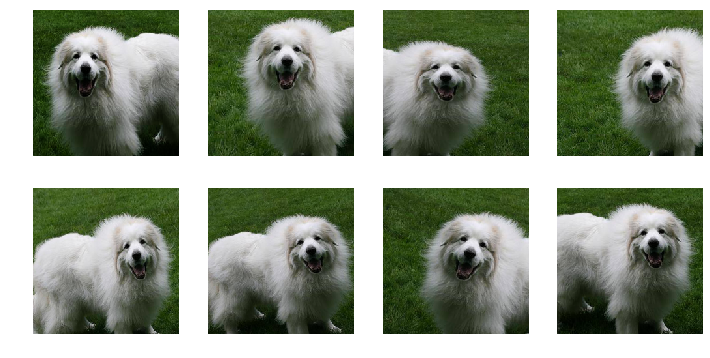

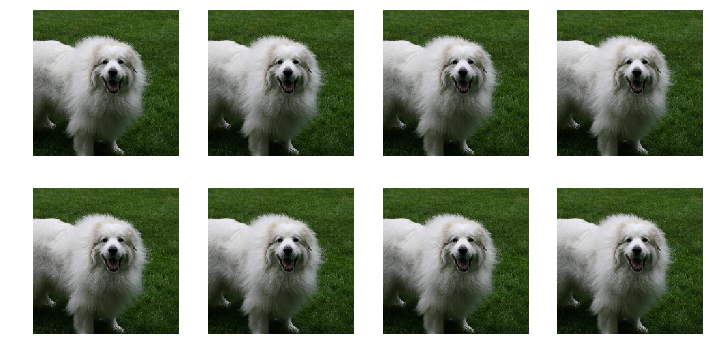

In [12]:
for t, tfm in enumerate(tfms):
    print(t)
    plots_f(files, 15, t, 2, 4, 12, 6, size=224)

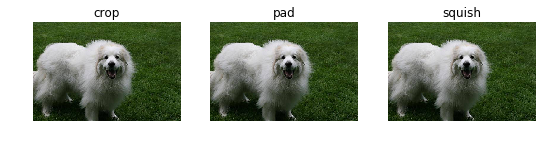

In [13]:
_, axs = plt.subplots(1, 3, figsize=(9, 5))
for rsz, ax in zip([ResizeMethod.CROP, ResizeMethod.PAD, ResizeMethod.SQUISH, ResizeMethod.mro], axs):
    (get_ex(files, 15).apply_tfms([crop_pad()], size=224, resize_method=224, padding_mode='zeros')
     .show(ax=ax, title=rsz.name.lower()))

In [14]:
# tfms = get_transforms(max_rotate=25, max_zoom=1.25)
# data = (ImageDataBunch.from_csv(path=path, csv_labels='labels.csv', folder='train', test='test',
#                                 valid_pct=0.2, size=sz, bs=bs, ds_tfms=tfms,
#                                 suffix='.jpg')).normalize(imagenet_stats)


In [15]:
# (ImageList.from_csv(path=path, csv_name='labels.csv', test='test')
#        .split_by_rand_pct(0.2, seed=2)
#        .label_from_df('breed')
#        .transform(tfms, size=sz)
#        .databunch(bs=bs)
#        .normalize(imagenet_stats))

In [25]:
def get_data(sz, bs):
    tfms = get_transforms(max_rotate=20, max_zoom=1.1, xtra_tfms= [flip_lr()] )
    data = (ImageList.from_df(df, path=path, folder='train', suffix='.jpg')
           .split_by_rand_pct(0.2, seed=2)
           .label_from_df('breed')
           .transform(tfms, size=sz)
           .databunch(bs=bs)
           .normalize(imagenet_stats))
    return data

In [26]:
data = get_data(224, 64)

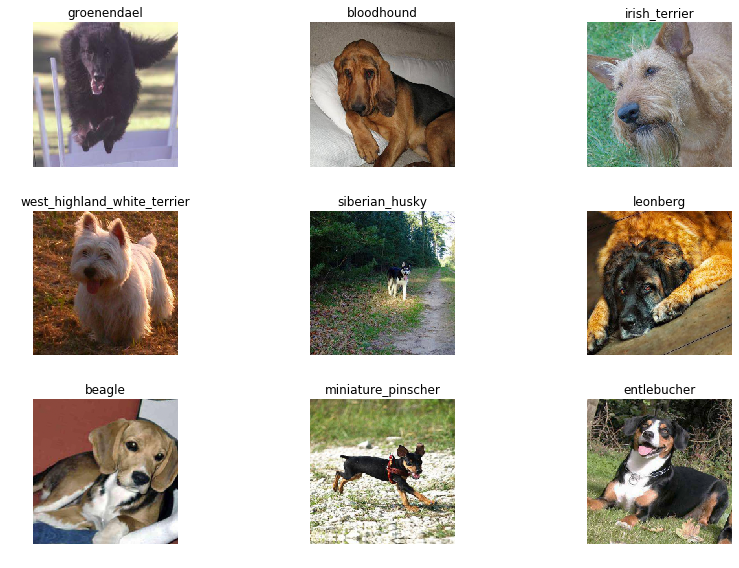

In [27]:
data.show_batch(rows=3, figsize=(12, 8))

In [28]:
learner = cnn_learner(data, models.resnet152, metrics=accuracy, path='.',callback_fns=[BnFreeze])

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /tmp/.torch/models/resnet152-b121ed2d.pth
241530880it [00:03, 65813219.43it/s]


In [29]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


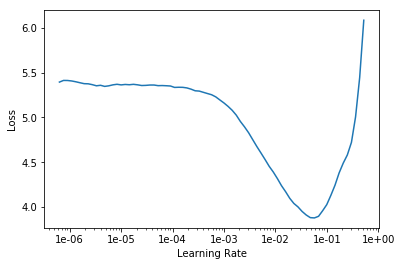

In [30]:
learner.recorder.plot()

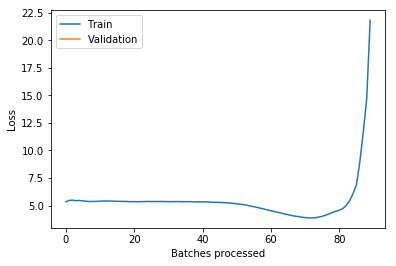

In [31]:
learner.recorder.plot_losses()

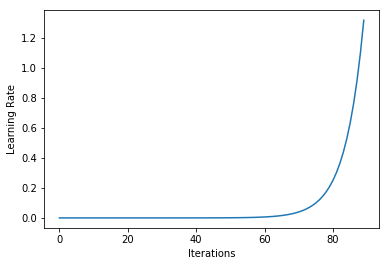

In [32]:
learner.recorder.plot_lr()

In [33]:
learner.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.539393,2.665675,0.395303,02:26
1,1.819231,1.781479,0.522994,02:19
2,1.304761,1.154777,0.667808,02:17
3,0.867922,0.714379,0.779354,02:17
4,0.569654,0.596405,0.810176,02:16


In [34]:
learner.save('224-Step1')

In [35]:
data = get_data(299, 32)

In [36]:
learner.data = data

In [39]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 65.50 MiB (GPU 0; 15.90 GiB total capacity; 14.85 GiB already allocated; 21.88 MiB free; 226.17 MiB cached)

In [ ]:
learner.recorder.plot()

In [ ]:
learner.fit_one_cycle(3, 1e-2)

In [ ]:
learner.recorder.plot_lr(show_moms=True)

In [ ]:
data = get_data(340, 32)

In [ ]:
learner.data = data

In [ ]:
learner.lr_find()

In [ ]:
learner.recorder.plot()

In [ ]:
learner.fit_one_cycle(5, 1e-2)

In [ ]:
learner.save('340-Unfrozen')

In [ ]:
learner.unfreeze()

In [ ]:
from fastai.callbacks import EarlyStoppingCallback

In [ ]:
learner.callback_fns.append(partial(EarlyStoppingCallback, monitor='accuracy', min_delta=0.01, patience=3))

In [ ]:
learner.lr_find()

In [ ]:
learner.recorder.plot()

In [ ]:
learner.fit_one_cycle(5, max_lr=slice(1e-7, 1e-5))

In [ ]:
gc.collect()

In [ ]:
learner.save('340-90plus')

In [ ]:
learner.load('340-90plus');

In [ ]:
learner.freeze_to(-2)

In [ ]:
learner.lr_find()

In [ ]:
learner.recorder.plot()

In [ ]:
learner.load('340-90plus');

In [ ]:
test_data = (ImageList.from_folder('../input/test')
             .split_none())

In [ ]:
test_data.transform

In [ ]:
src = (ImageList.from_folder('../input/test')
             .split_none())

In [ ]:
data = src.databunch(bs=bs).normalize(imagenet_stats)

In [ ]:
# src = (ImageList.from_folder('sample_data/oxford-iiit-pet/images', extensions='.jpg')
#                .split_none()
#                .label_empty() 
#                .transform(None, size=340) 
#                .databunch(bs=64) 
#                .normaliz(imagenet_stats))